In [1]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv
from pprint import pprint

# Load environment variables from .env
load_dotenv()
# Add src folder to path
project_root = Path.cwd().parent  # assumes notebook is in child folder
src_path = project_root / "sources"
sys.path.append(str(src_path))
from core.llm import OpenRouterClient
from utils.generate_dsl_docs import generate_symbolic_dsl_reference_markdown
from agents.agents_utils import MultiGridFeatureCollector, SymbolicGridMapper

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
from pathlib import Path

def save_solution_to_json(puzzle_id: str, rule: str, file_path: str):
    """
    Saves a solved puzzle's rule to a JSON file.

    Parameters:
    - puzzle_id: The ID of the puzzle (e.g., "000d3fb3").
    - rule: The DSL rule string that solves the puzzle.
    - file_path: The path to the JSON file where solutions are stored.
    """
    # Ensure the directory exists
    Path(file_path).parent.mkdir(parents=True, exist_ok=True)

    solutions = {}
    if Path(file_path).exists():
        try:
            # IMPORTANT CHANGE 1: Specify encoding='utf-8' for reading
            with open(file_path, 'r', encoding='utf-8') as f:
                solutions = json.load(f)
        except json.JSONDecodeError:
            print(f"Warning: Existing JSON file at {file_path} is empty or malformed. Starting fresh.")
            solutions = {}
        except FileNotFoundError:
            # This handles a rare case where the file exists but somehow becomes unavailable right before opening
            print(f"Warning: File not found at {file_path} despite existence check. Starting fresh.")
            solutions = {}


    solutions[puzzle_id] = rule

    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(solutions, f, indent=4, ensure_ascii=False)
    print(f"Solution for puzzle '{puzzle_id}' saved successfully to {file_path}")

In [3]:
# json_file = "/workspaces/arcprize2025/datas/arc-agi_training_challenges.json"
# json_file = r"C:\Users\UT00YBG3\Documents\arcprize2025\datas\arc-agi_training_challenges.json"
json_file = "/home/yann/ssd_storage/python/arcprize2025/datas/arc-agi_training_challenges.json"
solved_puzzles_json_path = "/home/yann/ssd_storage/python/arcprize2025/sources/assets/SYMB_A.json"

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot_grid(grid, title=""):
    """
    Plots a single 2D grid using matplotlib.
    
    Parameters:
    - grid: List of lists of integers.
    - title: Optional title for the plot.
    """
    my_custom_color_list = [
        '#000000', # 0: Black (background)
        '#FFD700', # 1: Gold (for 'レ' / I)
        '#00FFFF', # 2: Cyan (for target 'II')
        '#FF4500', # 3: OrangeRed (for target 'III')
        '#800080', # 4: Purple (example unused color)
        '#00FF00', # 5: Lime Green (example unused color)
        '#FFFF00', # 6: Yellow (example unused color)
        '#32CD32', # 7: LimeGreen (for target 'VII') - ensure distinct from 5
        '#0000FF', # 8: Blue (for 'ハ' / VIII) - explicitly requested
        '#FFC0CB'  # 9: Pink (example unused color)
        ]
    my_custom_cmap = mcolors.ListedColormap(my_custom_color_list)
    grid_array = np.array(grid)
    plt.figure(figsize=(2, 2))
    plt.imshow(grid_array, cmap=my_custom_cmap, interpolation='nearest', vmin=0, vmax=9)
    plt.title(title)
    plt.axis('off')
    plt.show()

--- Training Example 0 ---


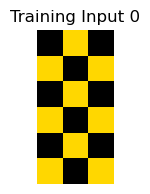

[[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]]


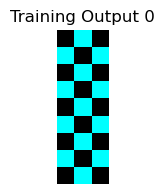

[[0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0]]
--- Training Example 1 ---


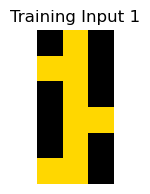

[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]]


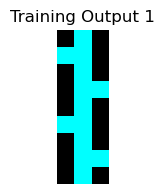

[[0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0]]
--- Training Example 2 ---


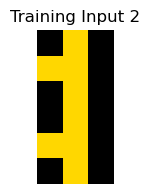

[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]]


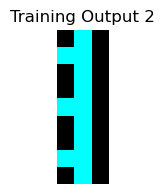

[[0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0]]
--- Test Example 0 ---


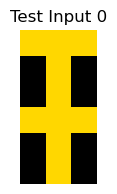

In [5]:
n=5


with open(json_file, 'r') as file:
    data = json.load(file)

data.keys()
list_number = list(data.keys())
puzzle_id = list_number[n]
puzzle = data[puzzle_id]

# Loop to plot all input/output pairs
for i, example in enumerate(puzzle["train"]):
    print(f"--- Training Example {i} ---")
    plot_grid(example["input"], title=f"Training Input {i}")
    pprint(example["input"])
    plot_grid(example["output"], title=f"Training Output {i}")
    pprint(example["output"])


for i, example in enumerate(puzzle["test"]):
    print(f"--- Test Example {i} ---")
    plot_grid(example["input"], title=f"Test Input {i}")


In [6]:
mapper = SymbolicGridMapper()
symbolic_variants = mapper.generate_variants(puzzle, symbol_set_ids=["katakana_bk"])
symbolics_grids = mapper.format_variants_list(symbolic_variants)
doc_sigil = generate_symbolic_dsl_reference_markdown()


In [7]:
import sys
sys.path.append(str(Path("/home/yann/ssd_storage/python/arcprize2025/tests/"))) 
sys.path.append(str(Path("/home/yann/ssd_storage/python/arcprize2025/sources/"))) 
from test_dsl_symbolic_executor import TEST_CASES
from assets.symbols import ROM_VAL_MAP

In [8]:


prompt = f"""
You are an advanced AI specializing in synthesizing solutions for Abstraction and Reasoning Corpus (ARC) puzzles.

---
**Task:**
Your primary task is to discover and formulate a *single, generalizable DSL rule* that transforms the given `input_grid` into the corresponding `output_grid` for *all* provided examples.

---
Valid test cases:
{TEST_CASES}

2.  **Input-Output Grid Examples:**
    This section provides a set of `(input_grid, output_grid)` pairs. Your synthesized rule must correctly generalize to all of them.
    {symbolics_grids}

---
**Rule Requirements:**
* The rule must be expressed as a **single symbolic DSL string**.
* It must use only the commands specified in the provided DSL documentation.
* It must be concise and represent a **generalizable transformation**, not just a specific solution for one example.
* It must only contains roman no numbers this is the mapping:
{ROM_VAL_MAP}
*  this symbols must be map to roman to  from 0 to 9: "symbols": ["∅", "レ", "ハ", "ア", "ヤ", "ユ", "ヨ", "キ", "ク", "ケ"]
---
**Strategy (Recommended):**
1.  Carefully analyze each `input_grid` and its corresponding `output_grid`.
2.  Identify the core transformation logic: What changes? What stays the same? Are there patterns of color changes, shape manipulations, positional shifts, or structural compositions?
3.  Consider how available DSL commands can be combined or parameterized to achieve this observed transformation.
4.  Formulate the most concise and general DSL string that applies to *all* provided examples.

---
**Output Format:**
Please provide the DSL rule string.
"""

In [9]:
print(prompt)


You are an advanced AI specializing in synthesizing solutions for Abstraction and Reasoning Corpus (ARC) puzzles.

---
**Task:**
Your primary task is to discover and formulate a *single, generalizable DSL rule* that transforms the given `input_grid` into the corresponding `output_grid` for *all* provided examples.

---
Valid test cases:
[('Ⳁ', array([[1]]), array([[1]])), ('Ⳁ', array([[0, 0],
       [0, 0]]), array([[0, 0],
       [0, 0]])), ('Ⳁ', array([1, 2, 3]), array([1, 2, 3])), ('⇒(II, I)', array([[1, 2, 3],
       [2, 0, 2]]), array([[1, 1, 3],
       [1, 0, 1]])), ('⇒(∅, X)', array([[0, 1],
       [0, 0]]), array([[10,  1],
       [10, 10]])), ('⇒(I, I)', array([[1, 2],
       [3, 1]]), array([[1, 2],
       [3, 1]])), ('↔', array([[1]]), array([[1]])), ('↔', array([[1, 2, 3]]), array([[3, 2, 1]])), ('↔', array([[1],
       [2],
       [3]]), array([[1],
       [2],
       [3]])), ('→(I, Ⳁ)', array([[1, 2],
       [3, 4]]), array([[1, 2],
       [3, 4]])), ('→(II, Ⳁ)', array([

In [17]:
rule = """⊞(⊕(IX, III, ∅), ⟹(⇒(I, II), ⬒(II)), ∅, ∅)"""


In [18]:
from core.dsl_symbolic_interpreter import SymbolicRuleParser
from core.dsl_symbolic_executor import DSLExecutor

parser = SymbolicRuleParser()

In [19]:
print(f"\n--- Evaluating Rule: '{rule}' for Puzzle ID: {puzzle_id} ---")

print("\n--- Training Examples Evaluation ---")
for i, example in enumerate(puzzle["train"]):
    input_grid_np = np.array(example["input"], dtype=int)
    output_grid_np = np.array(example["output"], dtype=int)

    score = 0.0
    result = None # Initialize result to None

    print(f"\n--- Training Example {i} ---")
    print("Input Grid:")
    pprint(input_grid_np.tolist())
    print("Expected Output Grid:")
    pprint(output_grid_np.tolist())

    try:
        # These are the three lines you requested, slightly adapted for loop
        command = parser.parse_rule(rule) 
        executor = DSLExecutor(
            root_command=command,
            initial_puzzle_input=input_grid_np,
        )
        result= executor.execute_program()
        
        if result.shape == output_grid_np.shape:
            compare = result == output_grid_np
            score = np.sum(compare) / (output_grid_np.shape[0] * output_grid_np.shape[1])
            print(f"Training Example {i} Score: {score:.4f}")
        else:
            print(f"Training Example {i} Score: 0.0000 (Shape mismatch: Expected {output_grid_np.shape}, Got {result.shape})")
            
    except Exception as e:
        print(f"Training Example {i} Score: 0.0000 (Error: {e})")
        print(f"Parsing/Execution Error: {e}") # Print the specific error for debugging

    if result is not None:
        print("Generated Output Grid:")
        pprint(result.tolist())
    else:
        print("No Generated Output Grid (due to error or parse failure).")

2025-07-20 14:12:04,771 - core.dsl_symbolic_executor - INFO - Executor initialization started.
2025-07-20 14:12:04,774 - core.dsl_symbolic_executor - INFO - Executor initialization complete.
2025-07-20 14:12:04,776 - core.dsl_symbolic_executor - INFO - Starting DSL program execution.
2025-07-20 14:12:04,776 - core.dsl_symbolic_executor - INFO - DSL program execution completed successfully.
2025-07-20 14:12:04,777 - core.dsl_symbolic_executor - INFO - Executor initialization started.
2025-07-20 14:12:04,779 - core.dsl_symbolic_executor - INFO - Executor initialization complete.
2025-07-20 14:12:04,780 - core.dsl_symbolic_executor - INFO - Starting DSL program execution.
2025-07-20 14:12:04,780 - core.dsl_symbolic_executor - INFO - DSL program execution completed successfully.
2025-07-20 14:12:04,783 - core.dsl_symbolic_executor - INFO - Executor initialization started.
2025-07-20 14:12:04,783 - core.dsl_symbolic_executor - INFO - Executor initialization complete.
2025-07-20 14:12:04,784


--- Evaluating Rule: '⊞(⊕(IX, III, ∅), ⟹(⇒(I, II), ⬒(II)), ∅, ∅)' for Puzzle ID: 017c7c7b ---

--- Training Examples Evaluation ---

--- Training Example 0 ---
Input Grid:
[[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]]
Expected Output Grid:
[[0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0]]
Training Example 0 Score: 1.0000
Generated Output Grid:
[[0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0],
 [2, 0, 2],
 [0, 2, 0]]

--- Training Example 1 ---
Input Grid:
[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]]
Expected Output Grid:
[[0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0]]
Training Example 1 Score: 0.9259
Generated Output Grid:
[[0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0]]

--- Training Example 2 ---
Input Grid:
[[0, 1, 0], [1, 1, 0], [0

In [13]:
# print(f"\nAll training examples passed for puzzle '{puzzle_id}'. Saving rule.")
# save_solution_to_json(puzzle_id, rule, solved_puzzles_json_path)